In [8]:
import os
import sys
import torch
import numpy as np
from torch import matmul as m
from matplotlib import pyplot as plt
from sdes import SDE,ConstantDiffusion,TwoDimensionalSynDrift,DoubleWellDrift
from torch.autograd.functional import jacobian

from torch.distributions import MultivariateNormal

sys.path.insert(0,".")

from utils import define_grid_ranges,define_mesh_points
from gps import MultivariateNormal,white_noise_kernel
from sde_gp import DenseGPSDE

In [3]:
# Define the drift and diffusion functions for the double well potential SDE
class DoubleWellDrift:
    def __init__(self, a=1.0, b=1.0):
        self.a = a
        self.b = b
    
    def __call__(self, x):
        x = -(self.a * x**3 - self.b * x)
        return x

class ConstantDiffusion:
    def __init__(self, sigma=0.5):
        self.sigma = sigma
    
    def __call__(self, x):
        return self.sigma * torch.ones_like(x)
    
class MaxDiffusion:
    def __init__(self, sigma=1.):
        self.sigma = sigma
    
    def __call__(self, x):
        D = self.sigma*torch.clamp(4. - 1.25*x**2,0.)
        return torch.sqrt(D)

# Run SDEs

In [35]:
dt = 0.002
number_of_steps = 5000
num_paths = 3
sigma = 1.

x_0 = torch.rand((1,)).unsqueeze(-1)
real_drift = DoubleWellDrift(a=4.,b=4.)
diffusion = MaxDiffusion()
#diffusion = ConstantDiffusion(sigma=sigma)


#x_0 = torch.rand((2,)).unsqueeze(0)
#drift = TwoDimensionalSynDrift()
#diffusion = ConstantDiffusion(sigma=sigma)

two_dimensional_sde = SDE(real_drift,diffusion,dt=dt)
dense_path_realization = two_dimensional_sde.simulate(x_0, number_of_steps, num_paths=num_paths)
dense_path_realization = dense_path_realization[0,:,:]

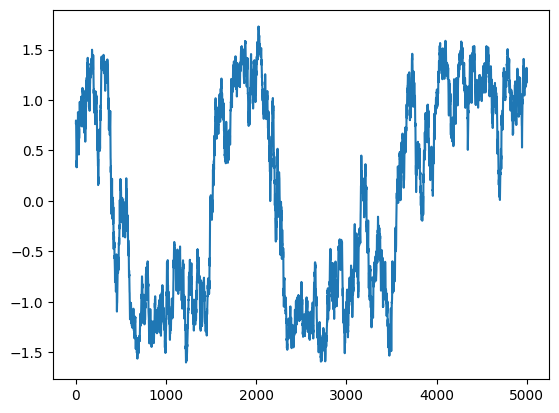

In [36]:
plt.plot(dense_path_realization[:,0].detach().numpy())

In [5]:
gp_path = r"C:\Users\cesar\Desktop\Projects\DiffusiveGenerativeModelling\OurCodes\markov_bridges\data\raw\gps\double_well_max_diffusion.tr"
data = {"dense_path_realization":dense_path_realization,
        "dt":dt,
        "sigma":sigma}
torch.save(data,gp_path)

### Select Path and Evaluation Grid 

In [21]:
from utils import define_grid_ranges,define_mesh_points
from sde_gp import DenseGPSDE

num_evaluation_points = 2000
num_inducing_points = 500

dimensions = dense_path_realization.size(1)
num_dense_points = dense_path_realization.size(0)

ranges_ = define_grid_ranges(dense_path_realization,ignore_percentatge=0.05)
evaluation_points = define_mesh_points(total_points = num_evaluation_points,n_dims = dimensions, ranges=ranges_)


### Inference

In [22]:
from gpytorch.kernels import (
    RBFKernel, 
    ScaleKernel,
    PolynomialKernel
)

In [37]:
#===============================================================================
j = 0
kernels_parameters = [(.05,1.),(1.,1.)]
sde_gp = DenseGPSDE(dense_path_realization,
                    dt,
                    kernel_parameters=kernels_parameters)
f_x = sde_gp(evaluation_points,diffusion)

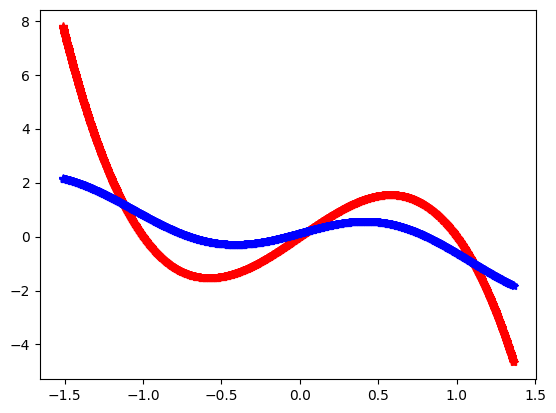

In [38]:
plt.plot(evaluation_points[:,j].detach().numpy(),real_drift(evaluation_points)[:,j].detach().numpy(),"r*")
plt.plot(evaluation_points[:,j].detach().numpy(),f_x[:,j].detach().numpy(),"b*")
plt.show()

In [18]:
#===============================================================================
j = 0
kernels_parameters = [(.1,1.),(1.,1.)]
sde_gp = DenseGPSDE(dense_path_realization,
                    dt,
                    kernels=[PolynomialKernel(power=4)])
f_x,D_x = sde_gp(evaluation_points)

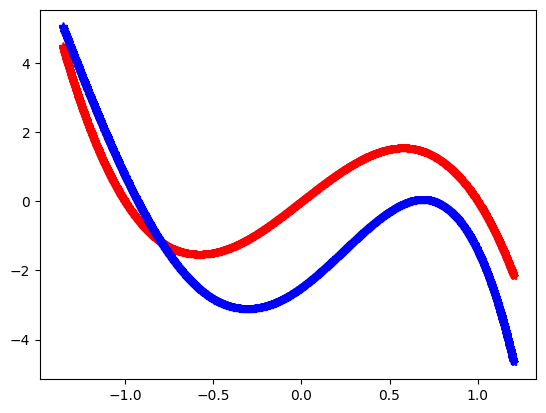

In [19]:
plt.plot(evaluation_points[:,j].detach().numpy(),real_drift(evaluation_points)[:,j].detach().numpy(),"r*")
plt.plot(evaluation_points[:,j].detach().numpy(),f_x[:,j].detach().numpy(),"b*")
plt.show()

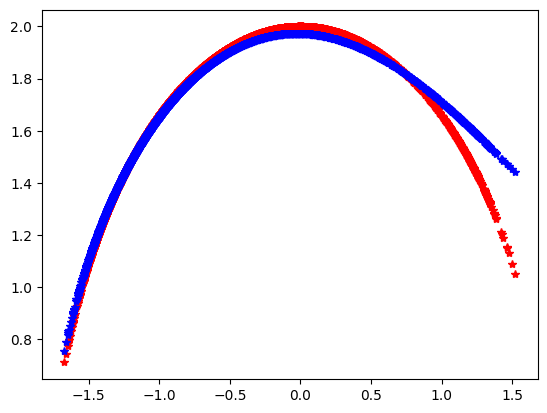

In [20]:
real_diffusion = diffusion(dense_path_realization[:-1])
plt.plot(dense_path_realization[:-1,j].detach().numpy(),real_diffusion[:,j].detach().numpy(),"r*")
plt.plot(dense_path_realization[:-1,j].detach().numpy(),torch.sqrt(torch.clamp(D_x[:,j],0.)).detach().numpy(),"b*")
plt.show()